# 15장. 심층 합성곱 신경망으로 이미지 분류

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch15/ch15.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch15/ch15.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

`watermark`는 주피터 노트북에 사용하는 파이썬 패키지를 출력하기 위한 유틸리티입니다. `watermark` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [2]:
#!pip install watermark

In [3]:
%load_ext watermark
%watermark -d -p numpy,scipy,tensorflow

2019-10-16 

numpy 1.16.3
scipy 1.2.1
tensorflow 2.0.0


**이 노트북을 실행하려면 텐서플로 2.0.0-alpha0 버전 이상이 필요합니다. 이전 버전의 텐서플로가 설치되어 있다면 다음 셀의 주석을 제거한 뒤 실행하세요.**

In [4]:
#!pip install tensorflow==2.0.0

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 GPU 버전의 텐서플로 2.0.0 버전을 설치하세요.**

In [5]:
#!pip install tensorflow-gpu==2.0.0

# 합성곱 신경망의 구성 요소

## 이산 합성곱 수행하기

### 합성곱 출력 크기 계산하기

In [6]:
import numpy as np


def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int(len(x)/s),s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

## 테스트:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]
print('Conv1d 구현: ', 
      conv1d(x, w, p=2, s=1))
print('넘파이 결과: ', 
      np.convolve(x, w, mode='same'))

Conv1d 구현:  [ 5. 14. 16. 26. 24. 34. 19. 22.]
넘파이 결과:  [ 5 14 16 26 24 34 19 22]


### 2D 이산 합성곱 수행하기

In [7]:
import numpy as np
import scipy.signal


def conv2d(X, W, p=(0,0), s=(1,1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1,n2))
    X_padded[p[0]:p[0] + X_orig.shape[0], 
             p[1]:p[1] + X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))
    
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1 , 2,0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
print('Conv2d 구현: \n', 
      conv2d(X, W, p=(1,1), s=(1,1)))

print('싸이파이 결과: \n', 
      scipy.signal.convolve2d(X, W, mode='same'))

Conv2d 구현: 
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
싸이파이 결과: 
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


# 기본 구성 요소를 사용하여 CNN 구성하기

## 여러 개의 입력 또는 컬러 채널을 다루기

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 실행하세요.**

In [8]:
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch15/example-image.png

In [9]:
import imageio

img = imageio.imread('./example-image.png', pilmode='RGB')
    
print('이미지 크기:', img.shape)
print('채널 수:', img.shape[2])
print('이미지 데이터 타입:', img.dtype)

print(img[100:102, 100:102, :])

이미지 크기: (252, 221, 3)
채널 수: 3
이미지 데이터 타입: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


# 텐서플로를 사용해 심층 합성곱 신경망 구현하기

## 데이터 적재와 전처리

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 실행하세요.**

In [10]:
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-images-idx3-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-labels-idx1-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-images-idx3-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-labels-idx1-ubyte.gz

In [11]:
## MNIST 데이터셋 압축을 풉니다.

import sys
import gzip
import shutil
import os


if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./')
                if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

In [12]:
import struct
import numpy as np


def load_mnist(path, kind='train'):
    """`path`에서 MNIST 데이터셋을 적재합니다."""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                                % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


X_data, y_data = load_mnist('./', kind='train')
print('행: %d,  열: %d' % (X_data.shape[0], X_data.shape[1]))
X_test, y_test = load_mnist('./', kind='t10k')
print('행: %d,  열: %d' % (X_test.shape[0], X_test.shape[1]))

X_train, y_train = X_data[:50000,:], y_data[:50000]
X_valid, y_valid = X_data[50000:,:], y_data[50000:]

print('훈련 세트: ', X_train.shape, y_train.shape)
print('검증 세트: ', X_valid.shape, y_valid.shape)
print('테스트 세트: ', X_test.shape, y_test.shape)

행: 60000,  열: 784
행: 10000,  열: 784
훈련 세트:  (50000, 784) (50000,)
검증 세트:  (10000, 784) (10000,)
테스트 세트:  (10000, 784) (10000,)


In [13]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

In [14]:
X_train_centered = X_train_centered.reshape((-1, 28, 28, 1))
X_valid_centered = X_valid_centered.reshape((-1, 28, 28, 1))
X_test_centered = X_test_centered.reshape((-1, 28, 28, 1))

In [15]:
from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train)
y_valid_onehot = to_categorical(y_valid)
y_test_onehot = to_categorical(y_test)

In [16]:
print(y_train[0], y_train_onehot[0])

5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [17]:
print('훈련 세트: ', X_train_centered.shape, y_train_onehot.shape)
print('검증 세트: ', X_valid_centered.shape, y_valid_onehot.shape)
print('테스트 세트: ', X_test_centered.shape, y_test_onehot.shape)

훈련 세트:  (50000, 28, 28, 1) (50000, 10)
검증 세트:  (10000, 28, 28, 1) (10000, 10)
테스트 세트:  (10000, 28, 28, 1) (10000, 10)


## 텐서플로 Keras API로 CNN 구성하기

In [18]:
from tensorflow.keras import layers, models

In [19]:
model = models.Sequential()

In [20]:
model.add(layers.Conv2D(32, (5, 5), padding='valid', 
                        activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), padding='valid', 
                        activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

## 합성곱 신경망 모델 훈련하기

In [22]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [23]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath='cnn_checkpoint.h5', 
                                 monitor='val_loss', 
                                 save_best_only=True), 
                 TensorBoard(log_dir="logs/{}".format(time.asctime()))]

In [24]:
history = model.fit(X_train_centered, y_train_onehot, 
                    batch_size=64, epochs=20, 
                    validation_data=(X_valid_centered, y_valid_onehot),
                    callbacks=callback_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 116us/sample - loss: 0.1358 - acc: 0.9586 - val_loss: 0.0474 - val_acc: 0.9862
Epoch 2/20
50000/50000 [==============================] - 4s 76us/sample - loss: 0.0461 - acc: 0.9855 - val_loss: 0.0400 - val_acc: 0.9879
Epoch 3/20
50000/50000 [==============================] - 4s 75us/sample - loss: 0.0358 - acc: 0.9887 - val_loss: 0.0465 - val_acc: 0.9866
Epoch 4/20
50000/50000 [==============================] - 4s 73us/sample - loss: 0.0289 - acc: 0.9906 - val_loss: 0.0446 - val_acc: 0.9874
Epoch 5/20
50000/50000 [==============================] - 4s 75us/sample - loss: 0.0243 - acc: 0.9919 - val_loss: 0.0373 - val_acc: 0.9895
Epoch 6/20
50000/50000 [==============================] - 4s 75us/sample - loss: 0.0187 - acc: 0.9942 - val_loss: 0.0390 - val_acc: 0.9905
Epoch 7/20
50000/50000 [==============================] - 4s 75us/sample - loss: 0.0177 - acc: 0.9945 - val_loss: 0

In [25]:
import matplotlib.pyplot as plt

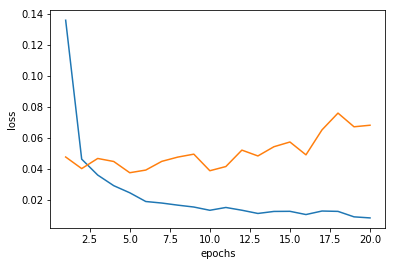

In [26]:
epochs = np.arange(1, 21)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

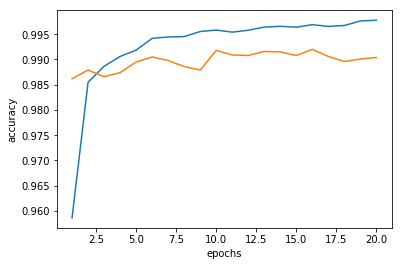

In [27]:
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [28]:
!ls -al logs/

합계 28
drwxr-xr-x 7 haesun haesun 4096 10월 16 17:34  .
drwxrwxr-x 4 haesun haesun 4096  8월 22 11:25  ..
drwxr-xr-x 2 haesun haesun 4096  3월 15  2019  .ipynb_checkpoints
drwxr-xr-x 4 haesun haesun 4096  6월 14 16:33 'Fri Jun 14 16:33:12 2019'
drwxr-xr-x 4 haesun haesun 4096  3월 25  2019 'Fri Mar 15 11:24:15 2019'
drwxr-xr-x 4 haesun haesun 4096  6월 12 11:54 'Wed Jun 12 11:54:48 2019'
drwxr-xr-x 4 haesun haesun 4096 10월 16 17:34 'Wed Oct 16 17:34:08 2019'


모델 저장

In [29]:
model.save('cnn_model.h5')

모델 복원

In [30]:
from tensorflow.keras.models import load_model

restored_model = load_model('cnn_model.h5')
restored_model.load_weights('cnn_checkpoint.h5')

테스트 정확도 확인

In [31]:
restored_model.evaluate(X_test_centered, y_test_onehot)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.03082024167277086, 0.9913]

테스트 샘플 예측 확인 + 이미지 출력

In [32]:
np.argmax(restored_model.predict(X_test_centered[:10]), axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [33]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

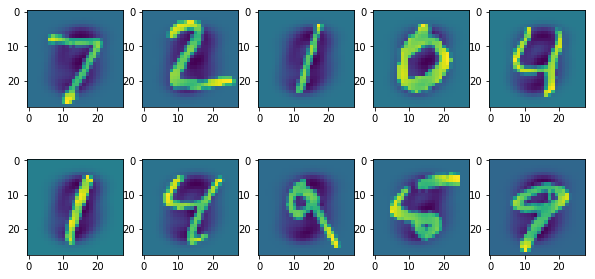

In [34]:
fig = plt.figure(figsize=(10, 5))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(X_test_centered[i].reshape(28, 28))

## 활성화 출력과 필터 시각화하기

In [35]:
first_layer = model.layers[0]
print(first_layer)

In [36]:
print(model.input)

Tensor("conv2d_input:0", shape=(None, 28, 28, 1), dtype=float32)


In [37]:
first_activation = models.Model(inputs=model.input, 
                                outputs=first_layer.output)
activation = first_activation.predict(X_test_centered[:10])

In [38]:
print(activation.shape)

(10, 24, 24, 32)


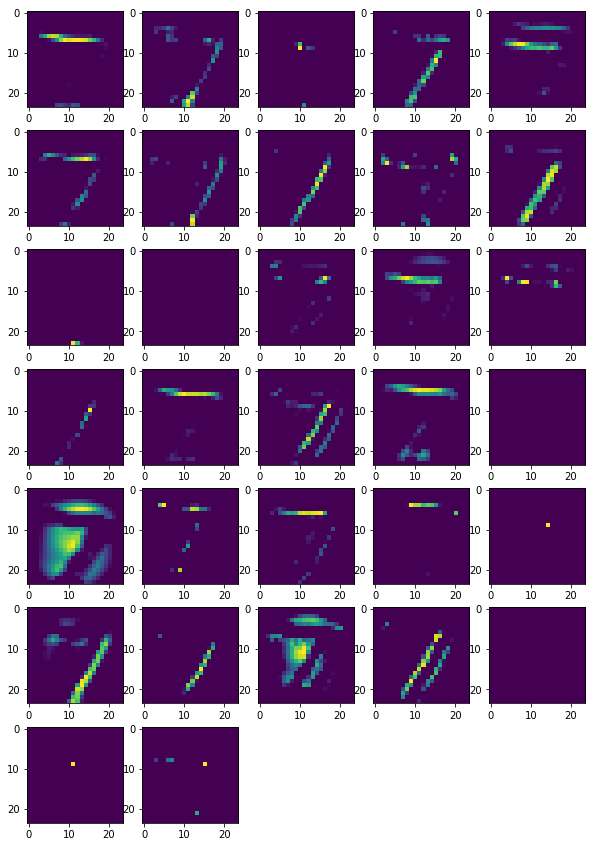

In [39]:
fig = plt.figure(figsize=(10, 15))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(activation[0, :, :, i])

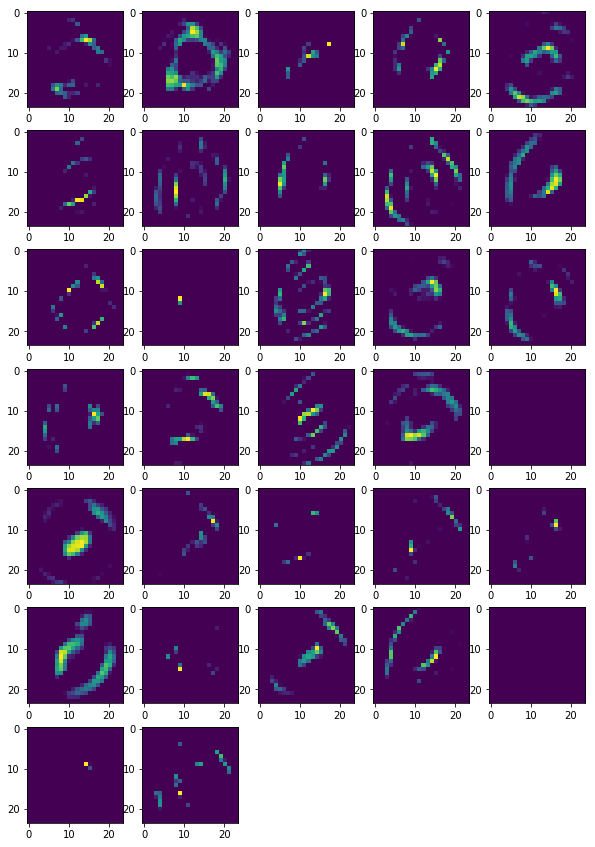

In [40]:
fig = plt.figure(figsize=(10, 15))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(activation[3, :, :, i])

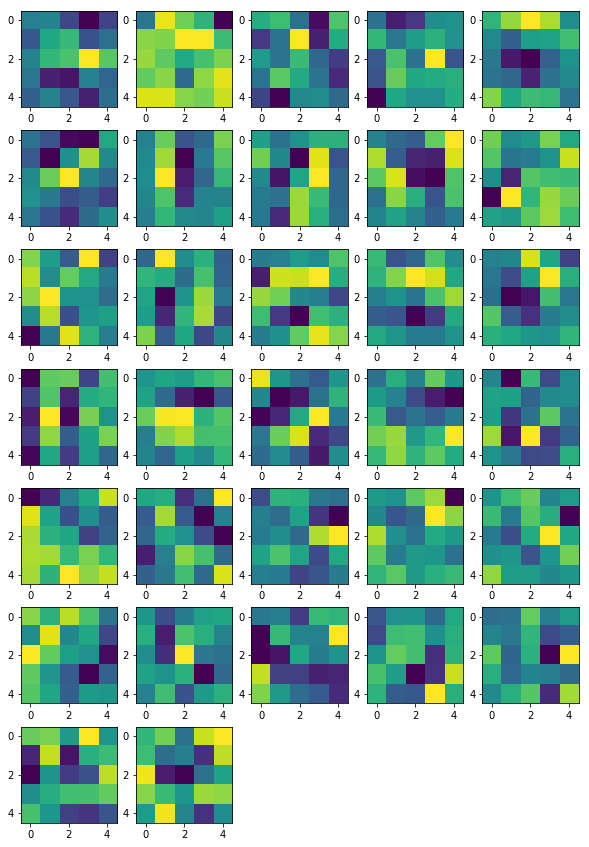

In [41]:
fig = plt.figure(figsize=(10, 15))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(first_layer.kernel[:, :, 0, i])

20번 더 훈련

In [42]:
restored_model.fit(X_train_centered, y_train_onehot, batch_size=64, epochs=20, 
                   validation_data=(X_valid_centered, y_valid_onehot))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 3s 67us/sample - loss: 0.0271 - acc: 0.9912 - val_loss: 0.0369 - val_acc: 0.9911
Epoch 2/20
50000/50000 [==============================] - 4s 71us/sample - loss: 0.0181 - acc: 0.9942 - val_loss: 0.0377 - val_acc: 0.9905
Epoch 3/20
50000/50000 [==============================] - 4s 70us/sample - loss: 0.0169 - acc: 0.9945 - val_loss: 0.0477 - val_acc: 0.9901
Epoch 4/20
50000/50000 [==============================] - 4s 71us/sample - loss: 0.0127 - acc: 0.9962 - val_loss: 0.0480 - val_acc: 0.9903
Epoch 5/20
50000/50000 [==============================] - 4s 73us/sample - loss: 0.0121 - acc: 0.9964 - val_loss: 0.0626 - val_acc: 0.9895
Epoch 6/20
50000/50000 [==============================] - 4s 71us/sample - loss: 0.0154 - acc: 0.9953 - val_loss: 0.0425 - val_acc: 0.9920
Epoch 7/20
50000/50000 [==============================] - 4s 72us/sample - loss: 0.0098 - acc: 0.9973 - val_loss: 0.